Import the main libraries

In [30]:
import pandas as pd  # Data manipulation and analysis, provides DataFrame and Series objects
import numpy as np  # Numerical operations, especially with arrays and mathematical functions
import matplotlib.pyplot as plt  # Plotting library for visualisations (e.g., line charts, bar charts)
import pandas_ta as ta  # Technical analysis indicators, built on top of pandas for financial data
import yfinance as yf  # Interface for accessing historical market data from Yahoo Finance
from sklearn.ensemble import RandomForestClassifier  # Machine learning classifier based on random forests
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV  # Tools for data splitting, cross-validation, and hyperparameter tuning
from sklearn.metrics import accuracy_score, classification_report  # Metrics for evaluating classification performance
from sklearn.preprocessing import StandardScaler  # Scales features to a standardised range, improves model performance
from sklearn.pipeline import Pipeline  # Enables streamlined processing by combining steps (scaling, modelling, etc.)
from sklearn.feature_selection import SelectKBest, f_classif  # Feature selection methods for identifying relevant features
import warnings  # Library to manage and filter warnings in the output
from filterpy.kalman import KalmanFilter  # Kalman filter algorithm for state estimation in time series
from filterpy.common import Q_discrete_white_noise  # Generates discrete white noise for use in Kalman filters

from backtesting import Backtest, Strategy  # Framework for running and analysing trading backtests
from datetime import datetime  # Date and time manipulation, essential for working with timestamps
from sklearn.tree import plot_tree  # Visualisation function to plot decision trees
import logging  # Standard logging module to track events and issues in code execution
from IPython.display import display, HTML 


In [31]:
# Turn off warnings
warnings.filterwarnings('ignore')

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# Class: `Features`

## Non-Technical Explanation:
The `Features` class is designed to analyze stock price data for a given financial instrument. It downloads historical price data, calculates various technical indicators (e.g., moving averages, RSI, Bollinger Bands), and prepares this data for trading analysis or prediction models. Additionally, it can visualize these indicators and save the data to an Excel file for further review.

## Summary
This class:
- Downloads historical stock price data
- Generates various technical indicators for trading analysis
- Prepares data for machine learning models
- Visualizes data and trading signals
- Allows data export to Excel for reporting

## Detailed Technical Description
The `Features` class contains methods to download and preprocess historical price data and calculate multiple technical indicators used in trading strategies. It supports:
- Generating moving averages (SMA)
- Calculating RSI, MACD, Bollinger Bands, and ATR
- Creating lagged features and applying Kalman filtering for smoother trend representation
- Plotting indicators, buy/sell signals, and Kalman-filtered data
- Saving processed data to Excel

The class is initialized with parameters specifying a financial instrument's ticker and date range for analysis. It uses `yfinance` to download data, `pandas` for data management, `matplotlib` for plotting, and `ta-lib` for technical indicators.

### Args
- `ticker` (str): The stock ticker symbol.
- `start_date` (str): The start date of the data in `YYYY-MM-DD` format.
- `end_date` (str): The end date of the data in `YYYY-MM-DD` format.

---

## Methods

### `__init__(self, ticker, start_date, end_date)`
Initializes the `Features` class with the ticker and date range and calls methods to download data and create indicators.

### `download_data(self)`
Downloads historical data using `yfinance` for the specified `ticker` and date range. It also processes the data by flattening columns, renaming columns, and handling missing values.
- **Columns Created:** Adjusted Close (`Adj_Close`)

### `create_features(self)`
Calculates and adds several technical indicators to the data. Adds calculated features to `self.features`.
- **Indicators Added:**
  - Simple Moving Averages (`SMA_10`, `SMA_50`)
  - Relative Strength Index (`RSI_14`, `RSI_7`, `RSI_21`)
  - Bollinger Bands (`BBL_20_2.0`, `BBM_20_2.0`, `BBU_20_2.0`)
  - Moving Average Convergence Divergence (`MACD_12_26_9`, `MACDs_12_26_9`, `MACDh_12_26_9`)
  - Average True Range (`ATR`)
  - Stochastic Oscillator (`STOCHk_14_3_3`, `STOCHd_14_3_3`)
  - On-Balance Volume (`OBV`)
  - Lag features for Close price and Volume

### `kalman_filter_price(self, prices)`
Applies a Kalman filter to smooth the Close price series.
  - **Returns:** A list of Kalman-filtered price predictions.
  - **Parameters:** `prices` (pd.Series): Close price data series.

### `prepare_data(self)`
Prepares the data for model training by creating lagged returns and target columns, setting up features and labels for predictive modeling.
  - **Returns:** Training and testing data splits (`X_train`, `X_test`, `y_train`, `y_test`) based on time-series split.

### `plot(self)`
Plots trading signals, returns, and various technical indicators for selected and non-selected indicators.
  - **Groups Plotted:** Moving Averages, Bollinger Bands, RSI, MACD, ATR, Stochastic Oscillator, OBV

### `save_to_excel(self)`
Saves the processed data to an Excel file, with the filename format reflecting the current timestamp.

### `plot_kalman_filter(self)`
Plots the Close price against the Kalman-filtered price for trend visualization.

---

## Calculations
### Moving Averages (SMA):
$$ \text{SMA}_{n} = \frac{1}{n} \sum_{i=0}^{n-1} \text{Price}_{t-i} $$

### Relative Strength Index (RSI):
$$
\text{RSI} = 100 - \frac{100}{1 + \text{RS}}
$$
Where RS is the ratio of average gains to average losses over a specified period.

### Bollinger Bands:
- Middle Band (Moving Average): \( \text{BBM}_{20} = \text{SMA}_{20} \)
- Upper Band: \( \text{BBU}_{20} = \text{BBM}_{20} + 2 \times \text{Standard Deviation} \)
- Lower Band: \( \text{BBL}_{20} = \text{BBM}_{20} - 2 \times \text{Standard Deviation} \)

### Average True Range (ATR):
$$
\text{ATR}_{n} = \frac{1}{n} \sum_{i=1}^{n} \text{True Range}_{i}
$$

### Kalman Filter:
The Kalman filter predicts a smoothed trend by estimating the system’s state iteratively.

---

## Notes
- The use of Kalman Filter is particularly useful for trend-following strategies.
- Technical indicators are widely used in quantitative trading models for identifying patterns in price behavior.

## Raises
- `ValueError`: If there are issues with data retrieval or processing, such as incompatible date formats.
- `TypeError`: If input parameters do not match the expected data types.

## Examples
```python
# Initialize the Features class for AAPL data between 2022-01-01 and 2023-01-01
features = Features(ticker="AAPL", start_date="2022-01-01", end_date="2023-01-01")

# Prepare data for machine learning
X_train, X_test, y_train, y_test = features.prepare_data()

# Plot technical indicators and signals
features.plot()

# Save data to an Excel file
features.save_to_excel()


In [32]:
class Features:
    def __init__(self, ticker, start_date, end_date,):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        
        self.data = pd.DataFrame()
        self.features = []  # List to hold feature names dynamically
        self.selected_features = []  # List to hold top N features
        
        self.grid_search = None
        self.download_data()
        self.create_features()

    def download_data(self):
        # Use yfinance to download data
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        # Flatten MultiIndex columns
        if isinstance(self.data.columns, pd.MultiIndex):
            self.data.columns = self.data.columns.get_level_values(0)
        self.data.dropna(inplace=True)
        # Ensure consistent column names
        if 'Adj Close' in self.data.columns:
            self.data = self.data.rename(columns={'Adj Close': 'Adj_Close'})
        else:
            self.data['Adj_Close'] = self.data['Close']
        logger.info(f"Downloaded data columns: {self.data.columns}")

    def create_features(self):
        # Calculate Simple Moving Averages
        self.data['SMA_10'] = ta.sma(self.data['Close'], length=10)
        self.data['SMA_50'] = ta.sma(self.data['Close'], length=50)
        self.features.extend(['SMA_10', 'SMA_50'])

        # Calculate Relative Strength Index
        self.data['RSI_14'] = ta.rsi(self.data['Close'], length=14)
        self.features.append('RSI_14')

                # Calculate Relative Strength Index
        self.data['RSI_7'] = ta.rsi(self.data['Close'], length=7)
        self.features.append('RSI_7')

                # Calculate Relative Strength Index
        self.data['RSI_21'] = ta.rsi(self.data['Close'], length=21)
        self.features.append('RSI_21')
        # Calculate Bollinger Bands
        bb = ta.bbands(self.data['Close'], length=20, std=2)
        self.data = pd.concat([self.data, bb], axis=1)
        bb_columns = bb.columns.tolist()
        self.features.extend(bb_columns)

        # Add MACD (Moving Average Convergence Divergence)
        macd = ta.macd(self.data['Close'])
        self.data = pd.concat([self.data, macd], axis=1)
        self.features.extend(macd.columns.tolist())

        # Add ATR (Average True Range)
        self.data['ATR'] = ta.atr(high=self.data['High'], low=self.data['Low'], close=self.data['Close'], length=14)
        self.features.append('ATR')

        # Add Stochastic Oscillator
        stoch = ta.stoch(high=self.data['High'], low=self.data['Low'], close=self.data['Close'])
        self.data = pd.concat([self.data, stoch], axis=1)
        self.features.extend(stoch.columns.tolist())

        # Add On-Balance Volume (OBV)
        self.data['OBV'] = ta.obv(self.data['Close'], self.data['Volume'])
        self.features.append('OBV')

        # Create Lag Features for Close Price and Volume
        for lag in [1, 2, 3, 5, 10]:
            self.data[f'Close_Lag_{lag}'] = self.data['Close'].shift(lag)
            self.data[f'Volume_Lag_{lag}'] = self.data['Volume'].shift(lag)
            self.features.extend([f'Close_Lag_{lag}', f'Volume_Lag_{lag}'])

        # Add Kalman Filter
        self.data['Kalman_Filter'] = self.kalman_filter_price(self.data['Close'])
        self.features.append('Kalman_Filter')

        # Remove any rows with NaN values after adding indicators
        self.data.dropna(inplace=True)
        logger.info(f"Data columns after adding indicators: {self.data.columns}")

    def kalman_filter_price(self,prices):
        n = len(prices)
        kf = KalmanFilter(dim_x=2, dim_z=1)
        kf.x = np.array([[prices.iloc[0]], [0.]])  # initial state (location and velocity)
        kf.F = np.array([[1.,1.],
                        [0.,1.]])    # state transition matrix
        kf.H = np.array([[1.,0.]])    # Measurement function
        kf.P *= 1000.                 # covariance matrix
        kf.R = 5                      # state uncertainty
        kf.Q = Q_discrete_white_noise(dim=2, dt=1, var=0.13)  # process uncertainty

        predictions = []
        for z in prices:
            kf.predict()
            kf.update([z])
            predictions.append(kf.x[0][0])

        return predictions

    def prepare_data(self):
        self.data['Return'] = self.data['Close'].pct_change()
        self.features.append('Return')
        self.data.dropna(inplace=True)

        # Define the target variable
        self.data['Target'] = np.where(self.data['Close'].shift(-1) > self.data['Close'], 1, 0)

        # Prepare features and target variable
        X = self.data[self.features]
        y = self.data['Target']

        # Remove rows with NaN values in target
        self.data.dropna(subset=['Target'], inplace=True)
        X = X.loc[self.data.index]
        y = y.loc[self.data.index]

        # Use time series split for realistic model validation
        tscv = TimeSeriesSplit(n_splits=5)
        train_indices, test_indices = next(tscv.split(X))
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

        return X_train, X_test, y_train, y_test


    def plot(self):
        # Plot Return, Prediction, and Trading Signals (same as before)
        plt.figure(figsize=(14, 7))
        # Plot Return as a bar chart
        plt.bar(self.data.index, self.data['Return'], color='lightgray', label='Return')
        # Plot Prediction as a line
        plt.plot(self.data.index, self.data['Prediction'], color='blue', label='Prediction', alpha=0.6)
        # Plot Buy Signals
        buy_signals = self.data[self.data['Signal'] == 'Buy']
        plt.scatter(buy_signals.index, buy_signals['Prediction'], marker='^', color='green', label='Buy Signal', s=100)
        # Plot Sell Signals
        sell_signals = self.data[self.data['Signal'] == 'Sell']
        plt.scatter(sell_signals.index, sell_signals['Prediction'], marker='v', color='red', label='Sell Signal', s=100)
        # Adding titles and labels
        plt.title('Daily Return, Prediction, and Trading Signals')
        plt.xlabel('Date')
        plt.ylabel('Values')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Separate features into selected and non-selected indicators
        non_selected_features = [feat for feat in self.features if feat not in self.selected_features]

        # Define indicator groups and their plotting functions
        indicator_groups = {
            'Moving Averages': ['SMA_10', 'SMA_50'],
            'Bollinger Bands': ['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0'],
            'RSI': ['RSI_14', 'RSI_7', 'RSI_21'],
            'MACD': ['MACD_12_26_9', 'MACDs_12_26_9', 'MACDh_12_26_9'],
            'ATR': ['ATR'],
            'Stochastic Oscillator': ['STOCHk_14_3_3', 'STOCHd_14_3_3'],
            'OBV': ['OBV'],
        }

        # Function to plot indicator groups
        def plot_indicator_group(group_name, indicators, title_suffix):
            plt.figure(figsize=(14, 5))
            if group_name in ['Moving Averages', 'Bollinger Bands']:
                plt.plot(self.data.index, self.data['Close'], label='Close Price', color='blue')
            for ind in indicators:
                if ind in self.data.columns:
                    plt.plot(self.data.index, self.data[ind], label=ind)
            plt.title(f'{group_name} {title_suffix}')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        # Plot selected indicators
        for group_name, indicators in indicator_groups.items():
            selected_inds = [ind for ind in indicators if ind in self.selected_features and ind in self.data.columns]
            if selected_inds:
                plot_indicator_group(group_name, selected_inds, '(Selected Indicators)')

        # Plot non-selected indicators
        for group_name, indicators in indicator_groups.items():
            non_selected_inds = [ind for ind in indicators if ind in non_selected_features and ind in self.data.columns]
            if non_selected_inds:
                plot_indicator_group(group_name, non_selected_inds, '(Non-Selected Indicators)')

    def save_to_excel(self):
        output_filename = f"trading_signals_TradingModel_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"
        if self.data.index.tz is not None:
            self.data.index = self.data.index.tz_localize(None)
        try:
            self.data.to_excel(output_filename, index=True, engine='openpyxl')
            logger.info(f"Data successfully saved to {output_filename}")
        except Exception as e:
            logger.error(f"An error occurred while saving the Excel file: {e}")
    
    def plot_kalman_filter(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.data.index, self.data['Close'], label='Close Price', color='blue')
        plt.plot(self.data.index, self.data['Kalman_Filter'], label='Kalman Filter', color='red')
        plt.title('Close Price vs. Kalman Filter')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Class: `RandomForestStrategy`

## Non-Technical Explanation:
The `RandomForestStrategy` class is designed to implement a simple trading strategy based on predictions generated by a Random Forest model. The strategy determines buy, sell, and hold actions based on predicted price movements and manages risk by applying stop-loss and take-profit rules. The class logs each trading action and calculates the resulting profits or losses (PnL) for review.

## Summary
The `RandomForestStrategy` class:
- Executes buy and sell actions based on price predictions
- Uses stop-loss and take-profit thresholds to manage risk
- Logs each trade with details like the action type, price, profit/loss, and current cash balance

## Detailed Technical Description
This class is initialized with a starting cash balance and a commission rate. It processes predictions from a machine learning model to decide when to buy or sell based on the current position. The stop-loss and take-profit parameters prevent excessive loss or secure gains by automatically closing positions under specified conditions.

### Args
- `cash` (float, optional): Starting cash balance, default is $10,000.
- `commission` (float, optional): Commission rate per trade, default is 0.2%.

---

## Methods

### `__init__(self, cash=10000, commission=0.002)`
Initializes the strategy with the initial cash balance and commission rate.

### `init(self)`
Prepares initial values for the strategy, including the price prediction series, stop-loss and take-profit percentages, action log, and position size.
- **Attributes Initialized:**
  - `prediction`: Converted list of integer predictions indicating expected price movement.
  - `position_log`: List to store each trade's details.
  - `stop_loss_pct`: Default stop-loss percentage, 5% (customizable).
  - `take_profit_pct`: Default take-profit percentage, 20% (customizable).

### `next(self)`
Executes the trading decision based on the latest prediction. The decision logic is as follows:
- **If prediction is 1:** Buys if not already in a position, setting a stop-loss and take-profit.
- **If prediction is 0:** Sells the current position if held.
- **Otherwise:** Holds the position.

This method ensures trades are taken only when conditions align with model predictions.
- **Actions Taken:**
  - `buy`: Triggers a buy order with stop-loss and take-profit levels.
  - `close`: Closes an existing position when a sell signal is received.

### `log_position(self)`
Records the details of each trade action in the `position_log`, including the action taken, price at transaction, profit/loss, position size, and current equity.
- **Data Logged:**
  - `Action`: The type of trade action taken (e.g., Buy, Sell).
  - `Date`: Date of the trade action.
  - `Price`: Close price at the time of trade.
  - `PnL`: Profit or loss of the position.
  - `Equity`: Current cash balance.

### `report_positions(self)`
Returns the `position_log`, allowing review of each recorded trade action and the details of profit/loss per trade.

---

## Calculations
### Stop-Loss and Take-Profit Levels:
Stop-loss level is calculated as:
$$ \text{Stop-Loss} = \text{Current Price} \times (1 - \text{stop\_loss\_pct}) $$
Take-profit level is calculated as:
$$ \text{Take-Profit} = \text{Current Price} \times (1 + \text{take\_profit\_pct}) $$

These thresholds help in automatic risk management and profit securing based on the specified percentages.

---

## Notes
- This strategy is simple and purely dependent on predictions from a Random Forest model.
- Designed for short-term trading actions based on time-series predictions.
- Logs each action’s details for performance tracking and analysis.

## Raises
- `ValueError`: If `cash` or `commission` values are invalid (e.g., negative or non-numeric).
- `KeyError`: If required data fields (e.g., `Prediction`) are missing in the input data.

## Examples
```python
# Initialize the strategy with default cash and commission values
strategy = RandomForestStrategy(cash=10000, commission=0.002)

# Prepare strategy with initial values and prediction series
strategy.init()

# Execute a trading step
strategy.next()

# Retrieve the trade log for performance review
position_log = strategy.report_positions()
print(position_log)


In [33]:
class RandomForestStrategy(Strategy):
    stop_loss_pct = 0.05  # Default value
    take_profit_pct = 0.2  # Default value

    def init(self):
        self.prediction = self.I(lambda: self.data['Prediction'].astype(int).tolist())
        self.position_log = []
        self.action = 'Trading Starts'
        self.current_position = 0

    def next(self):
        if self.action != 'Trading Starts':
            self.log_position()
        current_prediction = self.prediction[-1]

        if current_prediction == 1 and self.position.size == 0:
            self.current_position = self.position.size
            self.buy(sl=self.data.Close[-1] * (1 - self.stop_loss_pct),
                     tp=self.data.Close[-1] * (1 + self.take_profit_pct))
            self.action = 'Buy'
        elif current_prediction == 0 and self.position.size > 0:
            self.current_position = self.position.size
            self.position.close()
            self.action = 'Sell'
        else:
            self.action = 'Hold'

    def log_position(self):
        self.position_log.append({
            'Action': self.action,
            'Date': self.data.index[-1],
            'Price': self.data.Close[-1],
            'Transaction Size': self.current_position,
            'Position': self.position.size,
            'PnL': self.position.pl,
            'PnL%': self.position.pl_pct,
            'Equity': self.equity
        })

    def report_positions(self):
        return self.position_log

# Class: `RandomForest`

## Non-Technical Explanation:
The `RandomForest` class leverages machine learning to identify trading opportunities by analyzing historical price data. It trains a Random Forest classifier to predict whether a stock price will go up or down, and generates trading signals (buy or sell) accordingly. The class includes functionality for selecting the best features (data points) to use in predictions, optimizing model performance, and simulating trading to evaluate potential profits.

## Summary
The `RandomForest` class:
- Trains a Random Forest classifier on historical price data
- Selects top features for optimized predictions
- Evaluates model performance and tunes parameters
- Generates buy/sell signals based on predictions
- Runs a simulated backtest of the trading strategy and logs trades

## Detailed Technical Description
This class initializes with a pre-trained model object, cash, commission, and configurable stop-loss and take-profit parameters. Using these parameters, it prepares and trains a Random Forest classifier on selected features, performs hyperparameter optimization, and generates buy/sell signals. Finally, it runs a backtest using the `RandomForestStrategy` to evaluate trading performance.

### Args
- `model` (object): The pre-trained model object containing price data and technical features.
- `number_of_features` (int, optional): Number of top features to select based on importance; if `None`, selects all features.
- `cash` (float, optional): Starting cash balance for the backtest, default is $10,000.
- `commission` (float, optional): Commission rate per trade, default is 0.2%.
- `stop_loss_pct` (float, optional): Stop-loss threshold, default is 5%.
- `take_profit_pct` (float, optional): Take-profit threshold, default is 20%.

---

## Methods

### `__init__(self, model, number_of_features=None, cash=10000, commission=0.002, stop_loss_pct=0.05, take_profit_pct=0.2)`
Initializes the `RandomForest` class with input parameters, sets up the Random Forest classifier, and determines the number of features to be selected for optimal model performance.

### `select_top_features(self, X)`
Filters and returns only the top features from the input data `X`, based on prior feature selection.
- **Args:** `X` (pd.DataFrame): Input feature data.
- **Returns:** `pd.DataFrame` with selected features.
- **Raises:** `ValueError` if top features are not yet selected.

### `evaluate_model(self, X_test, y_test)`
Evaluates the classifier’s performance on test data.
- **Args:** `X_test` (pd.DataFrame): Test feature data.
- **y_test** (pd.Series): True labels for the test set.
- **Metrics Calculated:** Accuracy score and classification report.

### `optimize_hyperparameters(self, X_train, y_train)`
Tunes the Random Forest model’s hyperparameters using GridSearchCV on a pipeline that includes feature scaling, feature selection, and classifier optimization.
- **Args:** `X_train` (pd.DataFrame): Training feature data.
- **y_train** (pd.Series): Training labels.
- **Params Tuned:** Number of estimators, max depth, minimum samples split, minimum samples leaf, max features, and selected features (`k`).

### `generate_signals(self)`
Generates buy/sell signals based on predictions from the Random Forest classifier and appends these to the model's data.
- **Signals Generated:** `Prediction` (1 for buy, 0 for sell), `Signal` column (interpreted as Buy or Sell).

### `plot_tree(self)`
Plots a single decision tree from the trained Random Forest for visualization and saves the plot as an image file.
- **File Saved:** `rf_individualtree.png`

### `train_model(self, X_train, y_train)`
Trains the Random Forest model on training data and calculates feature importances to identify the most impactful features.
- **Args:** `X_train` (pd.DataFrame): Training feature data.
- **y_train** (pd.Series): Training labels.
- **Returns:** Ordered feature importances.
- **Selected Features:** Logs the top `number_of_features` for further use.

### `run(self)`
Main execution function. It:
1. Trains the model and selects top features
2. Optimizes hyperparameters
3. Generates trading signals
4. Runs a backtest using the `RandomForestStrategy`
5. Saves the backtest results to an Excel file
- **Returns:** Backtest results including performance metrics.

---

## Calculations
### Feature Importances:
The top features are selected based on the calculated feature importance from the Random Forest model, sorted in descending order.

### Trading Signals:
Signals are generated based on the prediction from the Random Forest model. A signal of 1 is classified as a "Buy" action, while a signal of 0 is classified as a "Sell" action.

### Stop-Loss and Take-Profit Levels:
The `stop_loss_pct` and `take_profit_pct` thresholds are applied during trading as follows:
- Stop-loss level:  
  $$ \text{Stop-Loss} = \text{Current Price} \times (1 - \text{stop\_loss\_pct}) $$
- Take-profit level:  
  $$ \text{Take-Profit} = \text{Current Price} \times (1 + \text{take\_profit\_pct}) $$

---

## Notes
- `GridSearchCV` is used to identify optimal hyperparameters, enabling fine-tuning for prediction accuracy.
- The backtest uses `RandomForestStrategy` to simulate trading based on predictions and logs each trade's outcome.

## Raises
- `ValueError`: If top features have not been selected before calling `select_top_features` or `optimize_hyperparameters`.
- `KeyError`: If the input data lacks required columns (e.g., features or target labels).

## Examples
```python
# Initialize the RandomForest class with default parameters
rf_model = RandomForest(model=Features("AAPL", "2022-01-01", "2023-01-01"))

# Run the entire pipeline (training, optimization, backtesting)
results = rf_model.run()

# Print backtest results
print(results)


In [34]:
class RandomForest:
    
    def __init__(self, model,number_of_features=None,cash=10000, commission=0.002,stop_loss_pct=0.05,take_profit_pct=0.2):
        self.model = model
        self.cash = cash
        self.commission = commission
        self.stop_loss_pct = stop_loss_pct
        self.take_profit_pct = take_profit_pct
        if number_of_features is None:
            self.number_of_features = len(model.features)
        self.number_of_features = number_of_features
        self.rf_classifier = RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_split=30)

    def select_top_features(self, X):
        # Ensure that selected_features is populated
        if not self.selected_features:
            raise ValueError("Top features have not been selected. Ensure train_model is called first.")
        return X[self.selected_features]

    def evaluate_model(self, X_test, y_test):
        y_pred = self.rf_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        logger.info(f"Accuracy Score: {accuracy}")
        logger.info(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    def optimize_hyperparameters(self, X_train, y_train):
        # Ensure that selected_features is populated
        if not self.selected_features:
            raise ValueError("Top features have not been selected. Ensure train_model is called first.")

        # Dynamically determine the maximum number of features available for selection
        n_features = len(self.selected_features)
        k_values = [min(5, n_features), min(10, n_features), n_features]

        param_grid = {
            'classifier__n_estimators': [5,10, 20, 35, 50, 100, 150],
            'classifier__max_depth': [5, 10, 15, 20],
            'classifier__min_samples_split': [5, 10, 20, 30],
            'classifier__min_samples_leaf': [1, 2,5, 10, 15],
            'classifier__max_features': ['sqrt', 'log2'],
            'selectkbest__k': k_values
        }

        # Create a pipeline with StandardScaler, SelectKBest, and RandomForestClassifier
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('selectkbest', SelectKBest(score_func=f_classif)),
            ('classifier', RandomForestClassifier(random_state=42))
        ])

        # Initialize GridSearchCV with time-series compatible cross-validation
        self.grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=TimeSeriesSplit(n_splits=3),
            n_jobs=-1
        )
        self.grid_search.fit(X_train[self.selected_features], y_train)
        logger.info(f"Best parameters: {self.grid_search.best_params_}")
        logger.info(f"Best cross-validation score: {self.grid_search.best_score_}")

        # Extract classifier parameters from the best parameters
        best_params = {
            k.split('__')[1]: v for k, v in self.grid_search.best_params_.items() if k.startswith('classifier__')
        }

        # Update the classifier with the best parameters
        self.rf_classifier = RandomForestClassifier(**best_params, random_state=42)
        self.rf_classifier.fit(X_train[self.selected_features], y_train)

    def generate_signals(self):
        # Use only the selected top N features
        self.model.data['Prediction'] = self.rf_classifier.predict(self.model.data[self.selected_features])
        self.model.data['Signal'] = np.where(self.model.data['Prediction'] == 1, 'Buy', 'Sell')
        logger.info("Trading signals generated.")
        
    def plot_tree(self):
        estimator = self.rf_classifier.estimators_[0]
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), dpi=300)
        plot_tree(
            estimator,
            feature_names=self.selected_features,
            class_names=['Sell', 'Buy'],
            filled=True,
            max_depth=4
        )
        fig.savefig('rf_individualtree.png')
        logger.info("Decision tree plot saved.")
        
    def train_model(self, X_train, y_train):
        self.rf_classifier.fit(X_train, y_train)
        logger.info("Model training complete.")

        # Calculate feature importances
        importances = self.rf_classifier.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': importances
        })
        feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
        logger.info(f"Feature Importances:\n{feature_importance_df}")

        # Select the top N features based on importance
        self.selected_features = feature_importance_df['Feature'].iloc[:self.number_of_features].tolist()
        logger.info(f"Top {self.number_of_features} features: {self.selected_features}")

        
    def run(self):
        print('--------------------------------')
        print('Running the Random Forest Model')
        print('--------------------------------')
        
        print('Preparing the data')
        X_train, X_test, y_train, y_test = self.model.prepare_data()
        
        # Initial training to get feature importances
        print('Training the model')
        self.train_model(X_train, y_train)
        
        # Select top N features
        print('Selecting the top features')
        X_train_top = self.select_top_features(X_train)
        X_test_top = self.select_top_features(X_test)
        
        # Retrain the model with top N features
        print('Retraining the model with the top features')
        self.rf_classifier.fit(X_train_top, y_train)
        logger.info("Model retrained with top features.")
        
        # Evaluate the model
        print('Evaluating the model')
        self.evaluate_model(X_test_top, y_test)
        
        # Continue with optimization, generating signals, and backtesting
        
        print('Optimizing the hyperparameters')
        self.optimize_hyperparameters(X_train_top, y_train)
            
        print('Generating the trading signals')
        self.generate_signals()
        
        print('Plotting the decision tree')
        self.plot_tree()
        
        print('Plotting the model')
        self.model.plot()
      
        self.model.save_to_excel()
        
        # Prepare data for backtesting
        print('Preparing the data for backtesting')
        data_for_backtest = self.model.data[['Open', 'High', 'Low', 'Close', 'Volume', 'Prediction']].copy()
        data_for_backtest['Prediction'] = data_for_backtest['Prediction'].astype(int)
        data_for_backtest.columns = data_for_backtest.columns.astype(str)
        data_for_backtest.index = pd.to_datetime(data_for_backtest.index)
        data_for_backtest = data_for_backtest.dropna()

        print('Running the backtest')
        bt = Backtest(data_for_backtest, RandomForestStrategy, cash=self.cash, commission=self.commission, exclusive_orders=True)
        results = bt.run(stop_loss_pct=self.stop_loss_pct, take_profit_pct=self.take_profit_pct)
        bt_file = f"backtest_results_random_forest_{self.model.ticker}.html"
        bt.plot(filename=bt_file)
        with open(bt_file, "r") as file:
            html_content = file.read()
        display(HTML(html_content))
        trade_log_df = pd.DataFrame(results._strategy.report_positions())
        if 'Date' in trade_log_df.columns:
            trade_log_df['Date'] = pd.to_datetime(trade_log_df['Date']).dt.tz_localize(None)
        tradingLog_filename = f"tradingLog_TradingModel_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"
        trade_log_df.to_excel(tradingLog_filename, index=False)
        logger.info(results)
        return results


# Function: `main`

## Non-Technical Explanation:
The `main` function is designed to set up and execute a backtest of a trading strategy for Tesla (TSLA) stock using a Random Forest model. It defines key parameters such as the stock ticker, date range, initial cash, commission rate, stop-loss, and take-profit levels, then initializes the `Features` and `RandomForest` classes to generate predictions and assess trading performance.

## Summary
The `main` function:
- Sets the parameters for the stock to analyze (`ticker`, `start_date`, `end_date`)
- Configures model parameters like starting cash, commission, stop-loss, and take-profit thresholds
- Initializes the `Features` and `RandomForest` classes for data handling and model training
- Runs the backtest for a `RandomForest` trading model, generating predictions and trade signals

## Detailed Technical Description
The function specifies parameters for the backtest and trading strategy. It initializes a `Features` instance for data acquisition and feature engineering, and then a `RandomForest` instance for model training, signal generation, and backtesting. If additional models are supported in the future, this function could include them with a simple conditional check.

### Key Parameters
- `model_to_run` (str): The model to execute, currently supports 'random_forest'.
- `ticker` (str): Stock symbol, here set to Tesla (`TSLA`).
- `start_date` (str): Start date of data collection (`YYYY-MM-DD`).
- `end_date` (str): End date of data collection.
- `cash` (float): Initial cash balance, default is $10,000.
- `commission` (float): Commission rate per trade, default is 0.2%.
- `stop_loss_pct` (float): Stop-loss threshold, default is 5%.
- `take_profit_pct` (float): Take-profit threshold, default is 20%.

---

## Workflow
1. Initializes `Features` for historical price data download and indicator calculation.
2. Sets up the `RandomForest` class for model training, signal generation, and backtest execution.
3. Executes the backtest using the `run` method in `RandomForest`, generating an Excel file with trading logs.

---

## Notes
- The function supports easy parameter modification for testing with different stocks, cash, or trading thresholds.
- Can be extended to include other trading models by updating `model_to_run`.

---

## Example Usage
```python
# Run the main function to initiate the backtest for Tesla with the defined parameters
main()


[*********************100%***********************]  1 of 1 completed
INFO:__main__:Downloaded data columns: Index(['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
INFO:__main__:Data columns after adding indicators: Index(['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10',
       'SMA_50', 'RSI_14', 'RSI_7', 'RSI_21', 'BBL_20_2.0', 'BBM_20_2.0',
       'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'ATR', 'STOCHk_14_3_3',
       'STOCHd_14_3_3', 'OBV', 'Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_2',
       'Volume_Lag_2', 'Close_Lag_3', 'Volume_Lag_3', 'Close_Lag_5',
       'Volume_Lag_5', 'Close_Lag_10', 'Volume_Lag_10', 'Kalman_Filter'],
      dtype='object')
INFO:__main__:Model training complete.
INFO:__main__:Feature Importances:
          Feature  Importance
26  Volume_Lag_10    0.211935
24   Volume_Lag_5    0.094245
2          RSI_14    0.072253
28         Return    0.069113
20   

--------------------------------
Running the Random Forest Model
--------------------------------
Preparing the data
Training the model
Selecting the top features
Retraining the model with the top features
Evaluating the model
Optimizing the hyperparameters


INFO:__main__:Best parameters: {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 10, 'selectkbest__k': 29}
INFO:__main__:Best cross-validation score: 0.5982905982905983
INFO:__main__:Trading signals generated.


Generating the trading signals
Plotting the decision tree


INFO:__main__:Decision tree plot saved.


Plotting the model


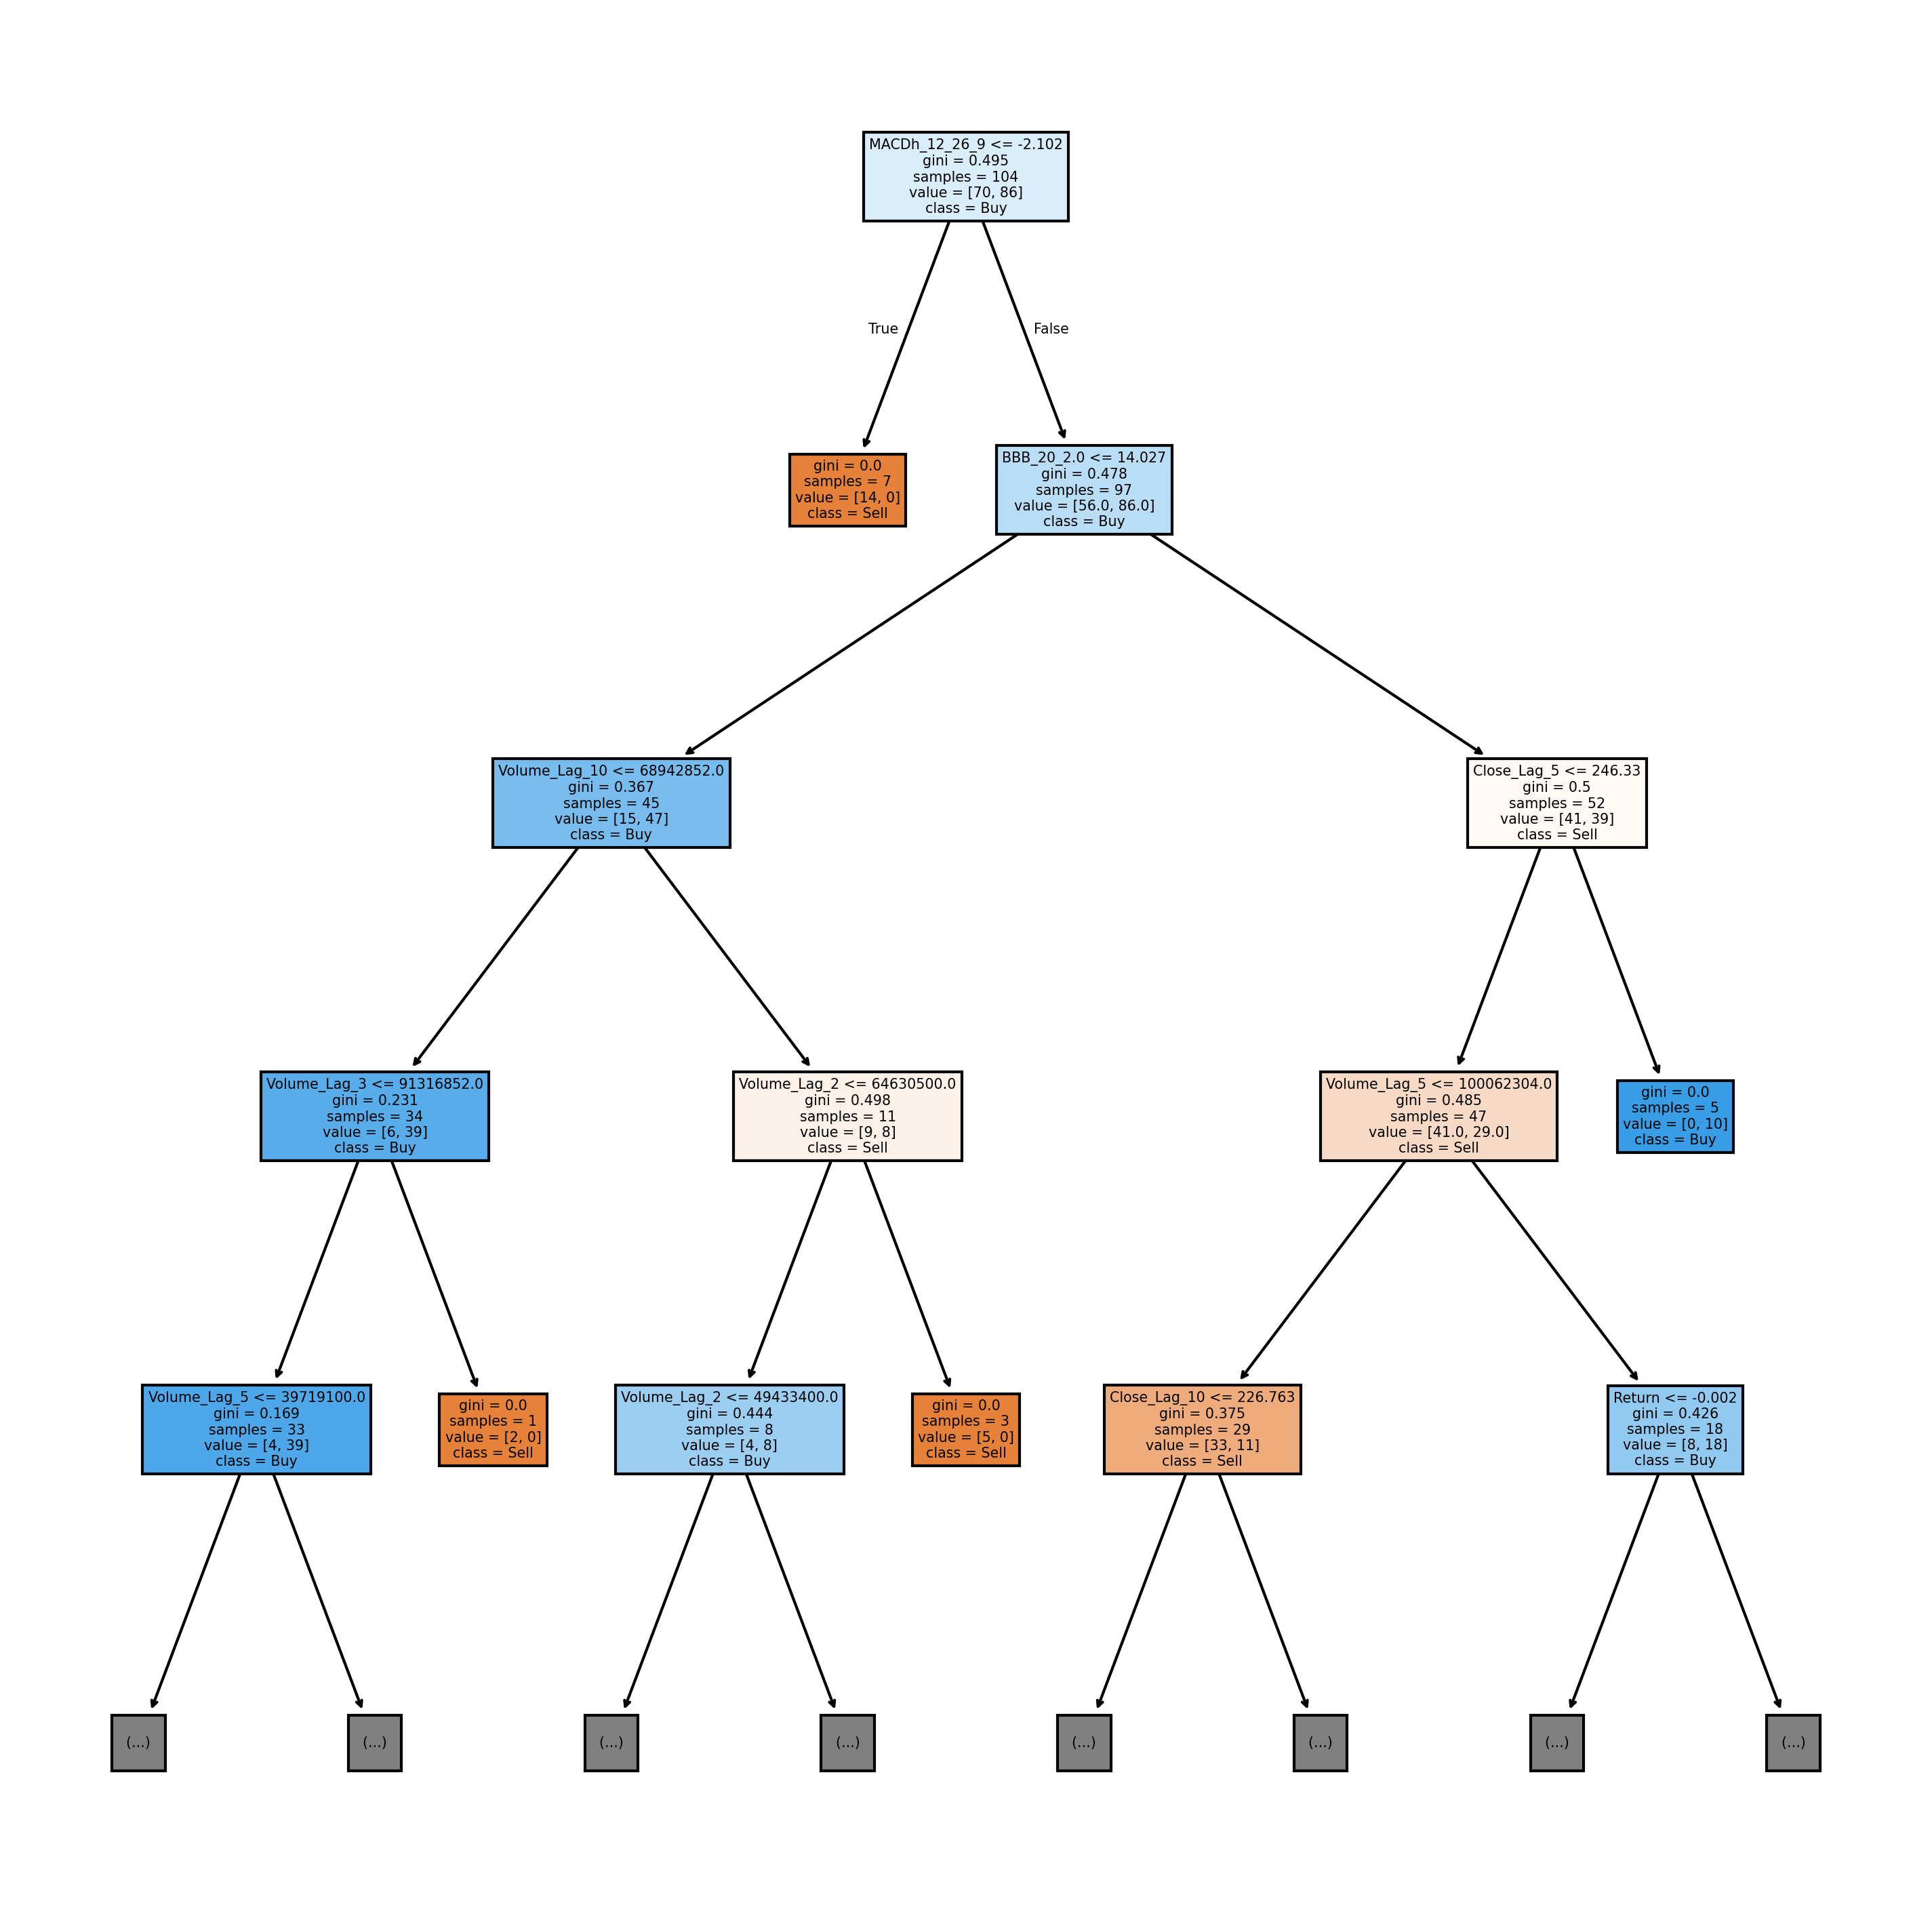

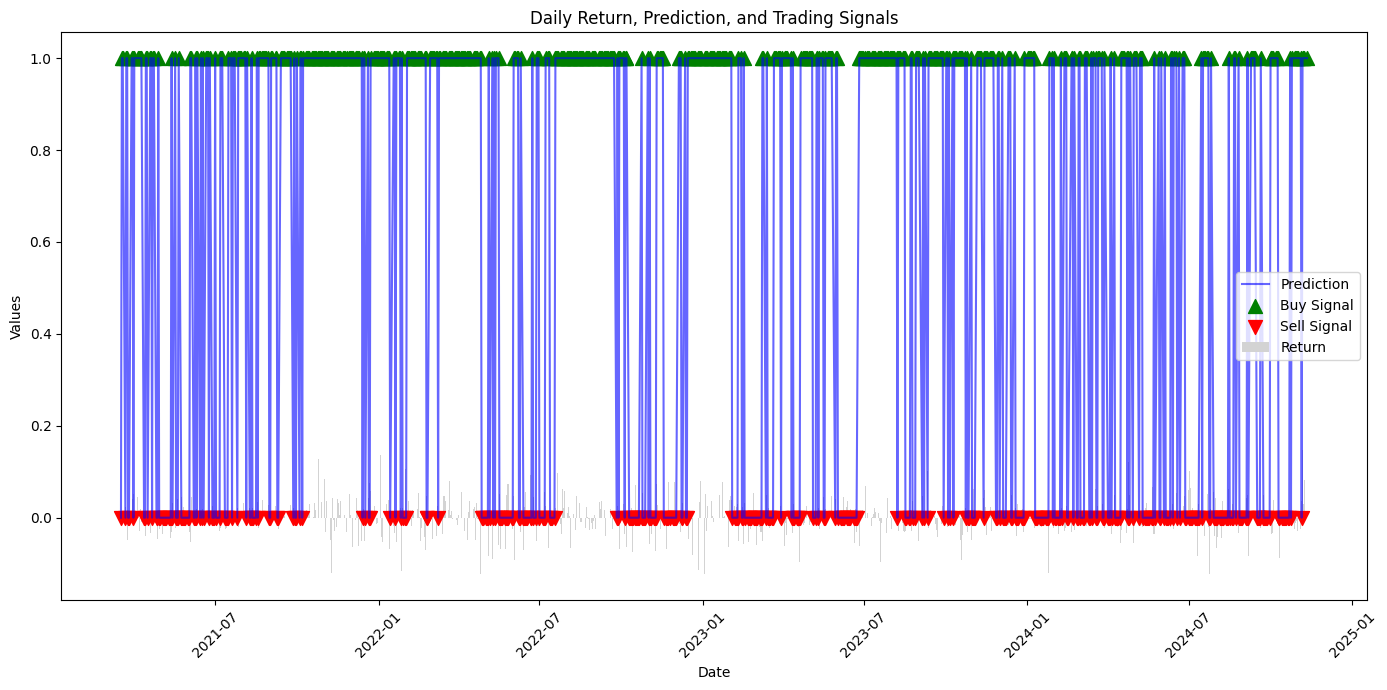

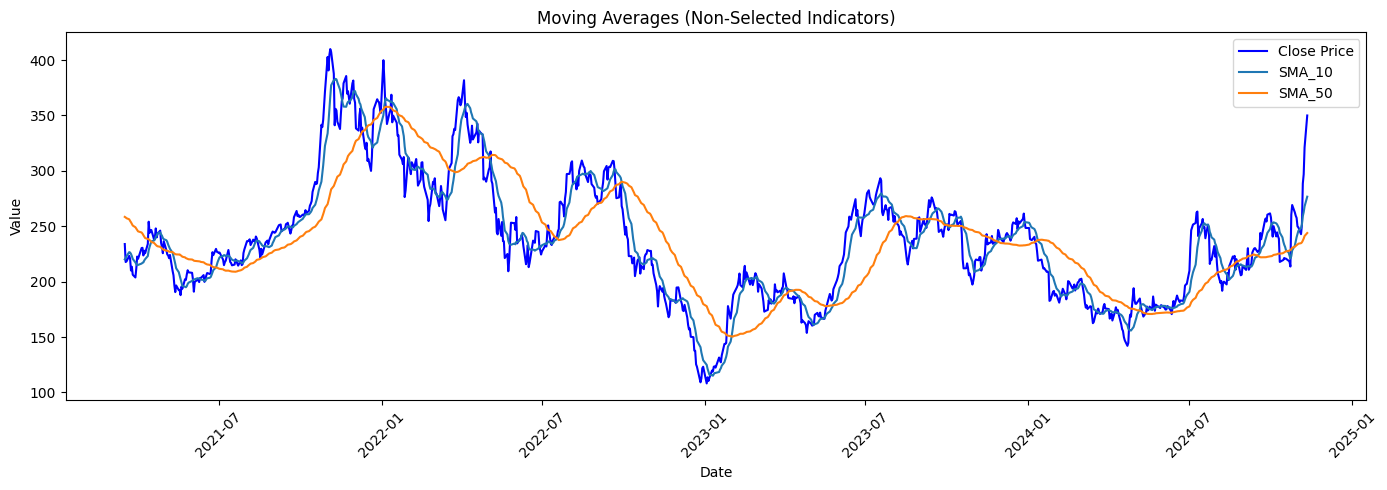

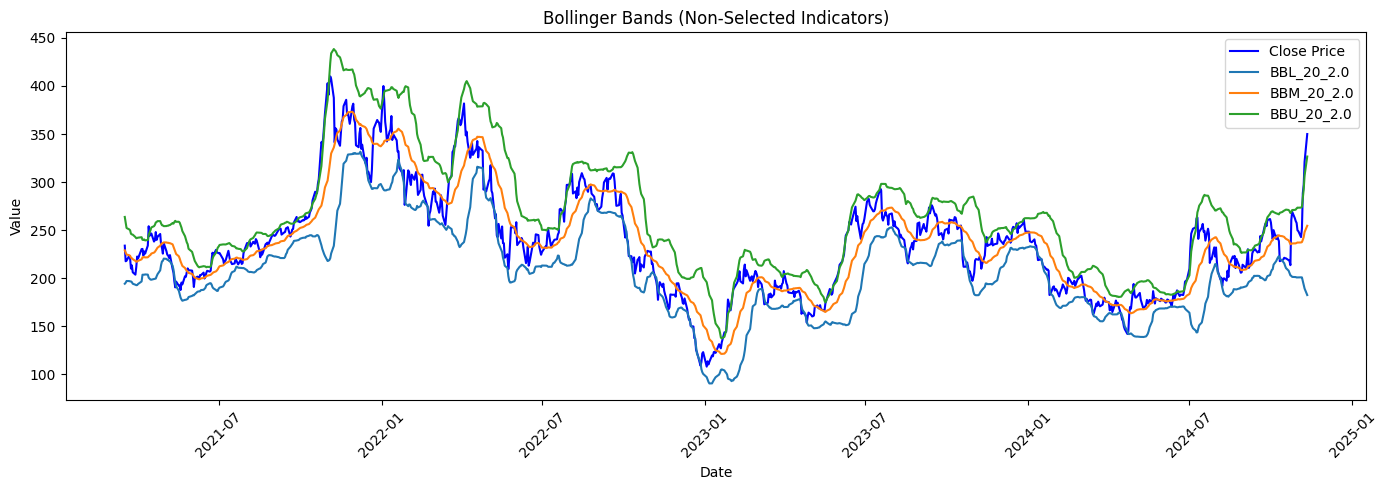

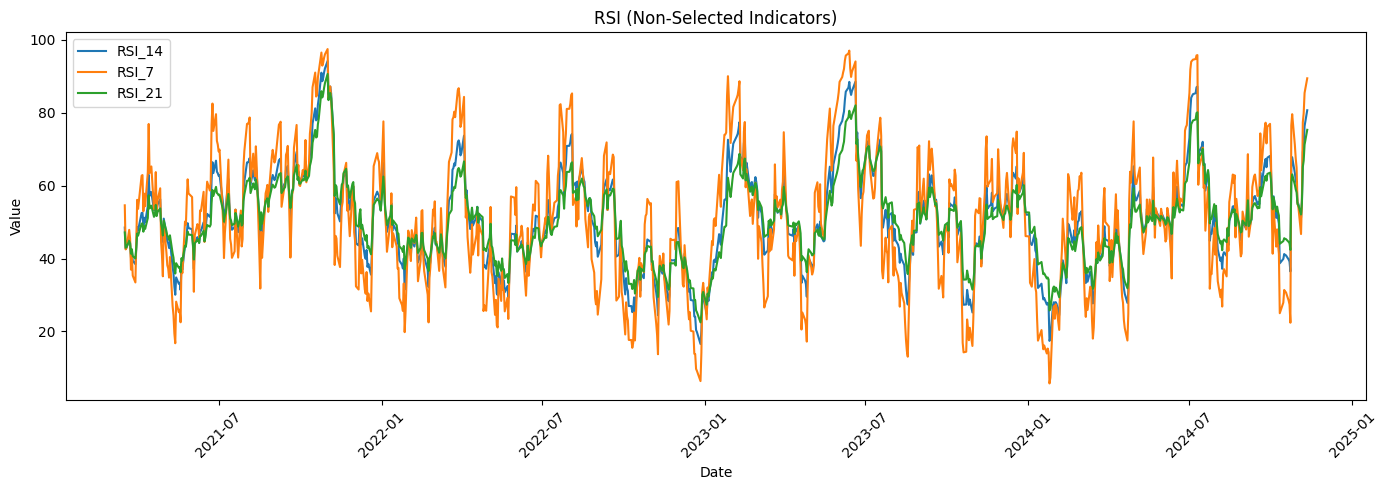

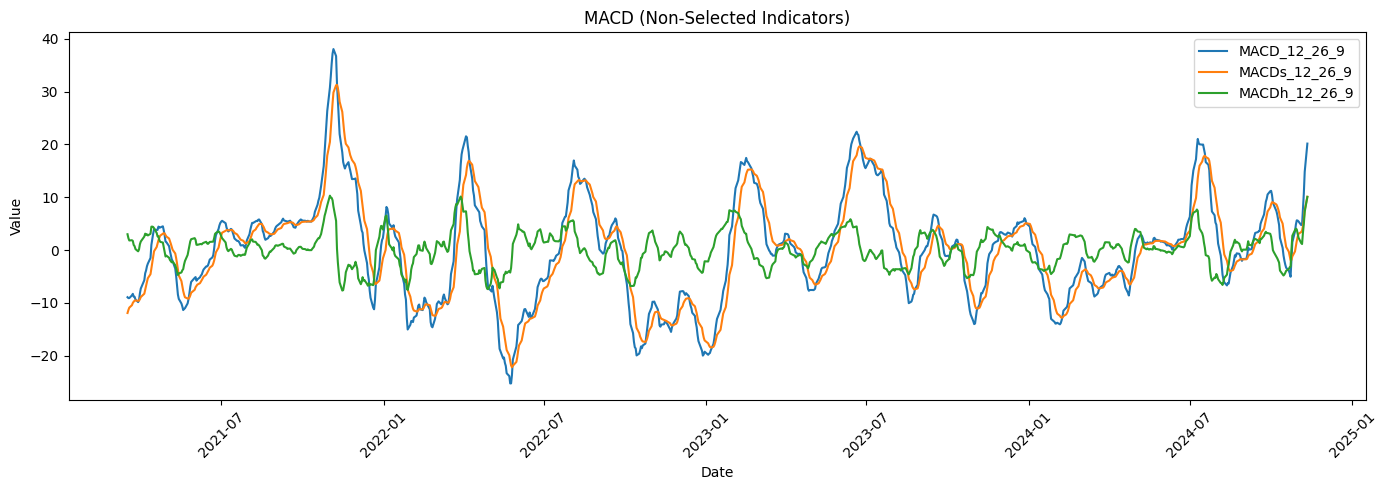

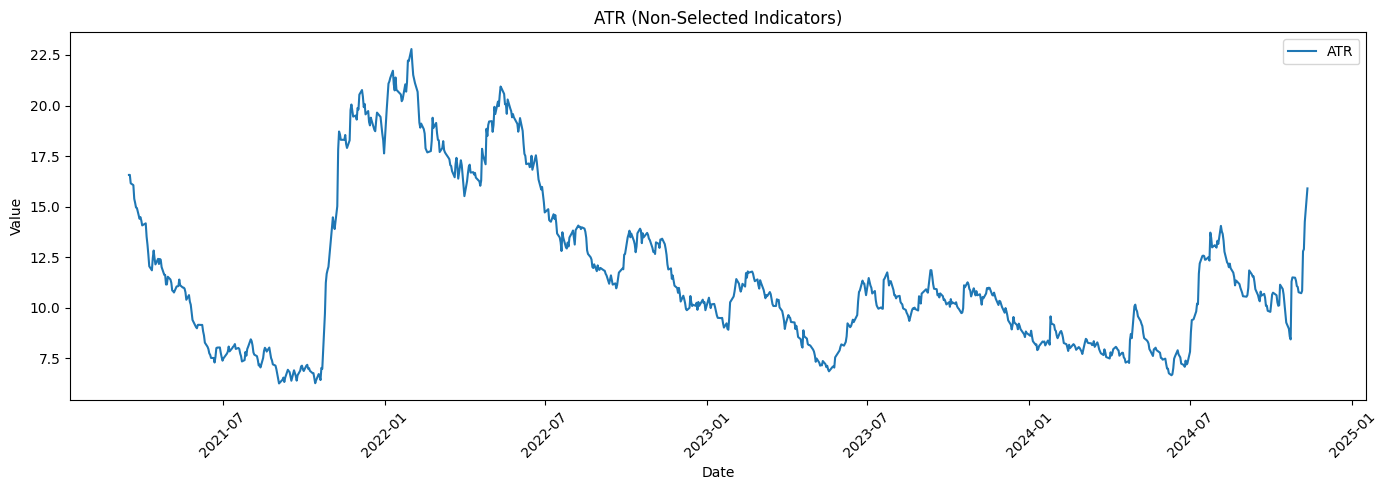

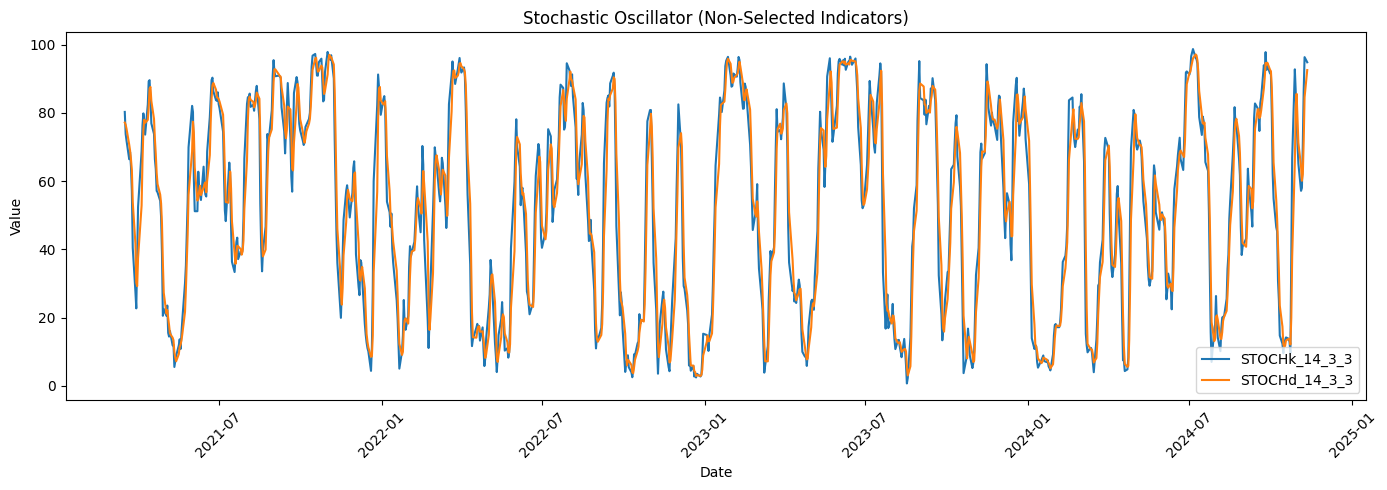

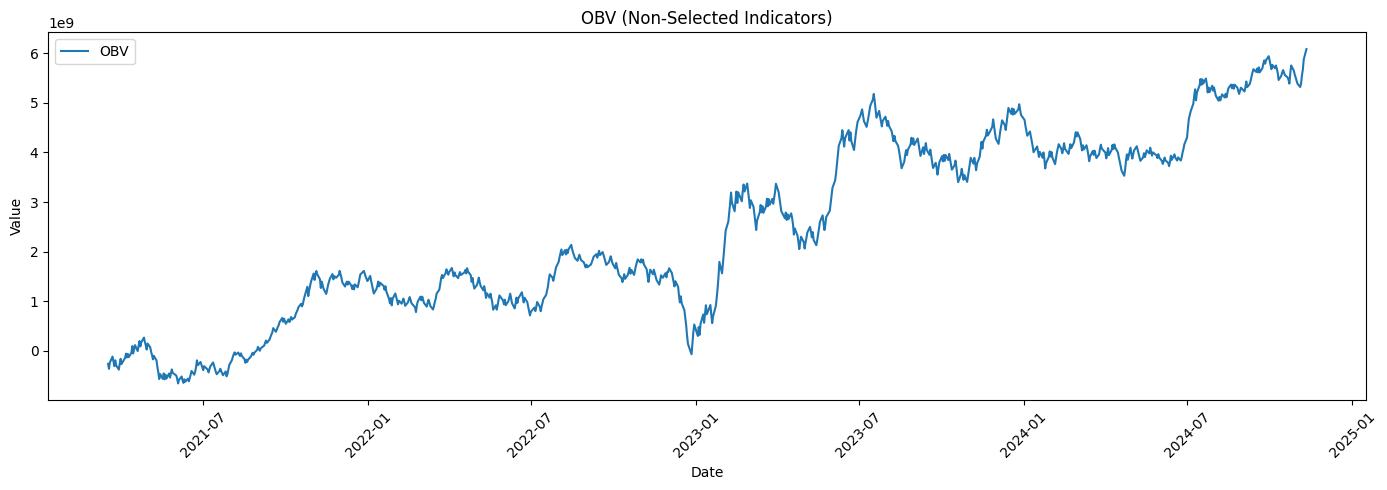

INFO:__main__:Data successfully saved to trading_signals_TradingModel_20241112_164429.xlsx
INFO:bokeh.io.state:Session output file 'backtest_results_random_forest_TSLA.html' already exists, will be overwritten.


Preparing the data for backtesting
Running the backtest


INFO:__main__:Start                     2021-03-17 00:00:00
End                       2024-11-11 00:00:00
Duration                   1335 days 00:00:00
Exposure Time [%]                   72.312704
Equity Final [$]                  23433.63462
Equity Peak [$]                  29041.747233
Return [%]                         134.336346
Buy & Hold Return [%]               49.613147
Return (Ann.) [%]                   26.239106
Volatility (Ann.) [%]               54.201522
Sharpe Ratio                         0.484103
Sortino Ratio                        0.967932
Calmar Ratio                         0.360851
Max. Drawdown [%]                  -72.714463
Avg. Drawdown [%]                   -6.310979
Max. Drawdown Duration     1085 days 00:00:00
Avg. Drawdown Duration       60 days 00:00:00
# Trades                                  191
Win Rate [%]                         49.21466
Best Trade [%]                      25.452379
Worst Trade [%]                     -10.40262
Avg. Trade [%]      

In [35]:
def main():
    
    model_to_run = 'random_forest'
    ticker = 'TSLA'
    start_date='2021-01-01'
    end_date='2024-11-12'
    cash=10000
    commission=0.002
    stop_loss_pct=0.05
    take_profit_pct=0.2
    
    if model_to_run == 'random_forest':
        number_of_features=None
        data = Features(ticker=ticker, start_date=start_date, end_date=end_date)
        rf = RandomForest(model=data,number_of_features=number_of_features,cash=cash, commission=commission,stop_loss_pct=stop_loss_pct,take_profit_pct=take_profit_pct)
        rf.run()
    

if __name__ == "__main__":
    main()

